<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Извлечение-признаков" data-toc-modified-id="Извлечение-признаков-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Извлечение признаков</a></span></li><li><span><a href="#Обучение-сверточной-нейросети-на-картинках" data-toc-modified-id="Обучение-сверточной-нейросети-на-картинках-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обучение сверточной нейросети на картинках</a></span></li><li><span><a href="#Добавление-столбца-с-предсказаниями-нейросети-к-данным-с-голосом" data-toc-modified-id="Добавление-столбца-с-предсказаниями-нейросети-к-данным-с-голосом-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Добавление столбца с предсказаниями нейросети к данным с голосом</a></span></li><li><span><a href="#На-получившемся-датасете-обучаем-RandomForestClassifier" data-toc-modified-id="На-получившемся-датасете-обучаем-RandomForestClassifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>На получившемся датасете обучаем RandomForestClassifier</a></span></li><li><span><a href="#Готовим-submit-data" data-toc-modified-id="Готовим-submit-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Готовим submit data</a></span></li></ul></div>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
np.random.seed(42)

Для каждой арабской цифры имеется скан записи на бумаге (`./data/train/image`) и запись произношения на английском языке разными дикторами (`./data/train/voice`)

Требуется построить модель для классификации цифр

In [8]:
import os
import PIL

IMAGE_TRAIN_PATH = "./data/train/image"
VOICE_TRAIN_PATH = "./data/train/voice"
IMAGE_TEST_PATH = "./data/test/image/"
VOICE_TEST_PATH = "./data/test/voice/"

def read_image(path):
    return PIL.Image.open(path).convert('L')

In [12]:
import librosa
import librosa.display

In [13]:
def load_wav(path):
    return librosa.load(path, sr=8000)

In [14]:
durations = []

for name in os.listdir(VOICE_TRAIN_PATH):
    path = os.path.join(VOICE_TRAIN_PATH, name)
    signal, sr = load_wav(path)
    duration = signal.size / float(sr)
    durations.append(duration)

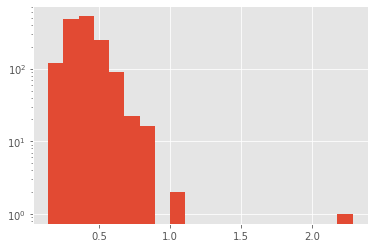

In [15]:
plt.hist(durations, bins=20)
plt.yscale('log');

In [16]:
sum_intensity = np.zeros((28, 28), dtype=np.float32)

zero_element_counts = []

for name in os.listdir(IMAGE_TRAIN_PATH):
    path = os.path.join(IMAGE_TRAIN_PATH, name)
    img = read_image(path)
    np_img = np.array(img)
    zero_count = (np_img < 1.0).astype(int).sum()
    zero_element_counts.append(zero_count)
    sum_intensity += np_img
    if zero_count > 735 or zero_count < 492:
        print(name)
    '''
    ipd.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(sum_intensity, cmap="plasma")
    plt.grid(False)
    plt.show()
    '''

0_127.png
1_20.png


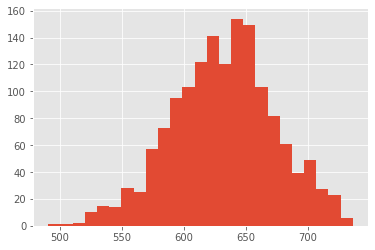

In [17]:
plt.hist(zero_element_counts, bins=25);

### Извлечение признаков

In [18]:
import pandas as pd

/home/ann/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [19]:
def extract_image_features(image_folder):
    image_vectors = []
    indices = []
    for image_name in os.listdir(image_folder):
        index = os.path.splitext(image_name)[0]
        indices.append(index)
        image = read_image(os.path.join(image_folder, image_name))
        image_vector = np.array(image).reshape(-1)
        image_vectors.append(image_vector)
    return pd.DataFrame({
        'index': indices,
        'image_vector': image_vectors,
    })

In [20]:
image_features_tr = extract_image_features(IMAGE_TRAIN_PATH)
image_features_te = extract_image_features(IMAGE_TEST_PATH)

In [21]:
def extract_voice_features(voice_folder, numcep=100, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

In [22]:
voice_features_tr = extract_voice_features(VOICE_TRAIN_PATH)
voice_features_te = extract_voice_features(VOICE_TEST_PATH)

In [23]:
dataset_tr = image_features_tr.merge(voice_features_tr, on='index')
dataset_te = image_features_te.merge(voice_features_te, on='index')

In [24]:
dataset_tr.shape

(1500, 3)

In [25]:
dataset_tr["target"] = dataset_tr["index"].apply(lambda x: int(x[0]))
dataset_te["target"] = dataset_te["index"].apply(lambda x: int(x[0]))

### Обучение сверточной нейросети на картинках

In [26]:
X_trainimg = np.vstack(dataset_tr["image_vector"].values/255)
y_trainimg = dataset_tr["target"]
X_testimg = np.vstack(dataset_te["image_vector"].values/255)
y_testimg = dataset_te["target"]

In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_trainimg = encoder.fit_transform(np.array(y_trainimg).reshape(-1, 1))
y_trainimg.shape

/home/ann/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1500, 10)

In [28]:
y_testimg = encoder.fit_transform(np.array(y_testimg).reshape(-1, 1))
y_testimg.shape

/home/ann/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(500, 10)

In [29]:
X_trainimg = X_trainimg.reshape(-1, 28, 28, 1)
X_testimg = X_testimg.reshape(-1, 28, 28, 1)

In [30]:
X_trainimg.shape

(1500, 28, 28, 1)

In [31]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.
/home/ann/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ann/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ann/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ann/.pyenv/versions/3.6

In [32]:
keras.backend.clear_session()

In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [38]:
model.fit(X_trainimg, y_trainimg,
          batch_size=30,
          epochs=15,
          verbose=1,
          validation_data=(X_testimg, y_testimg))

Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2540 - accuracy: 0.9253 - val_loss: 8.6333 - val_accuracy: 0.1100
Epoch 2/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1767 - accuracy: 0.9487 - val_loss: 10.1987 - val_accuracy: 0.1060
Epoch 3/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1396 - accuracy: 0.9500 - val_loss: 10.4624 - val_accuracy: 0.1080
Epoch 4/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1211 - accuracy: 0.9607 - val_loss: 10.5358 - val_accuracy: 0.1120
Epoch 5/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0946 - accuracy: 0.9667 - val_loss: 10.9879 - val_accuracy: 0.1120
Epoch 6/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0834 - accuracy: 0.9747 - val_loss: 11.0132 - val_accuracy: 0.1120
Epoch 7/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0627 -

In [39]:
pred=model.predict(X_testimg).argmax(axis=1)

In [40]:
def extract_voice_features(voice_folder, numcep=100, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

In [42]:
dataset_te

,index,image_vector,voice_vector,target
0,285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-454.70526, 54.62366, 11.140218, 22.32652, -8...",2
1,212,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-181.37611, 41.81173, 23.814613, 4.1566625, -...",2
2,361,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-220.0484, 46.701973, 9.449443, 9.587729, -4....",3
3,347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-227.78001, 158.38046, -45.224712, -39.631256...",3
4,428,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-195.73018, 93.947205, 9.354431, -37.064545, ...",4
...,...,...,...,...
495,411,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-138.72755, 80.69298, -26.852268, -38.903732,...",4
496,175,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-183.9127, 93.89262, 20.996738, -58.348854, -...",1
497,456,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-171.60304, 89.863045, -27.909735, -7.473554,...",4
498,476,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-189.14445, 49.78231, -8.477941, -0.78951895,...",4


### Добавление столбца с предсказаниями нейросети к данным с голосом

In [44]:
X_trainv = np.hstack((np.vstack(dataset_tr["voice_vector"].values),np.vstack(model.predict(X_trainimg).argmax(axis=1))))
y_trainv = dataset_tr["target"]
X_testv = np.hstack((np.vstack(dataset_te["voice_vector"].values),np.vstack(model.predict(X_testimg).argmax(axis=1))))


### На получившемся датасете обучаем RandomForestClassifier

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=5).fit(X_trainv, y_trainv)

In [47]:
clf.score(X_trainv, y_trainv)


0.9993333333333333

### Готовим submit data

In [49]:
submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH)
submit_dataset = submit_image_features.merge(
    submit_voice_features, 
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)

make prediction

In [50]:
submit_dataset["target"] = clf.predict(X_testv)

In [52]:
submit_dataset[["index", "target"]] \
    .sort_values("index") \
    .to_csv("random_submission1.csv", index=False)